# HyperParameter Tuning for LSTM models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd "/content/drive/My Drive/P2_TimeForecast/P2_CodeBase"

# install import-ipynb for importing helper modules
!pip install import-ipynb
import import_ipynb

# importing helper functions for data preprocessing and model visualization
import plotlib_helper as gplot
import datapreprocess_helper as dataprep

/content/drive/My Drive/P2_TimeForecast/P2_CodeBase
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp36-none-any.whl size=2976 sha256=4ca058603308789bb5a896526150260670a54244bfbe9e61b1a5fb11f40894b1
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
importing Jupyter notebook from plotlib_helper.ipynb
importing Jupyter notebook from datapreprocess_helper.ipynb


In [4]:
data_path = "/content/drive/My Drive/P2_TimeForecast/P2_CodeBase/data/"
dnn_path = "/content/drive/My Drive/P2_TimeForecast/P2_CodeBase/dnn/"

## Load Data

In [5]:
import pandas as pd
import io
import os
import requests
import numpy as np
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


filepath = os.path.join(data_path, "P2_Preprocessed_CNN_LSTM.csv")
df = pd.read_csv(filepath, na_values=['NA','?','-'])

print(df.dtypes , df.shape)
print()
print(df[0:5])
print()
print(df.isnull().sum())

Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
Output    float64
dtype: object (4392, 6)

       Open      High       Low     Close    Volume    Output
0 -0.894209 -0.885022 -0.892306 -0.884364  1.104812  4.125000
1 -0.883762 -0.886056 -0.885975 -0.888021 -0.497301  4.015625
2 -0.887941 -0.889159 -0.887558 -0.888543 -0.892217  4.000000
3 -0.887941 -0.890194 -0.891251 -0.893768 -0.000263  3.843750
4 -0.896820 -0.898986 -0.906551 -0.908920  3.729366  3.390625

Open      0
High      0
Low       0
Close     0
Volume    0
Output    0
dtype: int64


## Split dataframe into features and target

In [6]:
y = df['Output'].copy() # y is copy of close column
x = df.drop(columns=['Output'], axis= 1, inplace=False)


x = x.to_numpy(dtype="float32");
y = y.to_numpy(dtype="float32");
x[0:5]
print(x.shape, y.shape)


(4392, 5) (4392,)


## Converting array into 3D array for LSTM using to_sequence()

In [7]:
import numpy as np

def to_sequences(seq_size, input, target):
    x = []
    y = []

    for i in range(len(target)-seq_size-1):
        window = input[i:(i+seq_size)]
        after_window = target[i+seq_size]
        window = [x for x in window]
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [8]:
# each record is converted into 7X5 array
SEQ_SIZE = 7
x,y = to_sequences(SEQ_SIZE, x, y)
print(x.shape , y.shape)

(4384, 7, 5) (4384,)


## Splitting array into train & test set (70-30)

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=120)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print()
print("Training samples: {}".format(x_train.shape[0]))
print("Test samples: {}".format(x_test.shape[0]))

x_train shape: (3068, 7, 5)
x_test shape: (1316, 7, 5)
y_train shape: (3068,)
y_test shape: (1316,)

Training samples: 3068
Test samples: 1316


##  HyperParameter Tuning

####  **Multiple LSTM layers and Neuron Count** 


##### *CASE 1: Single LSTM layer*

In [ ]:
layers={'lstm': 128 ,'Dense': 64}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'lstm': 128, 'Dense': 64}, 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_layers_hp1.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
for i in range(5):
  model = Sequential()
  model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1,  activation='relu', input_shape=ip_size))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=100)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00012: early stopping
Epoch 00008: early stopping
Epoch 00017: early stopping
Epoch 00011: early stopping
Epoch 00007: early stopping
Elapsed time: 95.65474963188171


###### *CASE 1: Model Performance Evaluation*

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128)               68608     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 76,929
Trainable params: 76,929
Non-trainable params: 0
_________________________________________________________________

{'layers': {'lstm': 128, 'Dense': 64}, 'activation': ['ReLu'], 'optimizer': ['adam']}
-------- Performance Evalutation for  RNN-LSTM - Single layer  --------
-------- Parameters:  {'layers': {'lstm': 128, 'Dense': 64}, 'activation': ['ReLu'], 'optimizer': ['adam']}  --------

RMSE         : 1.5572765
MSE          : 2.42511
R2 score     : 0.9970470435682259

-------- Regression

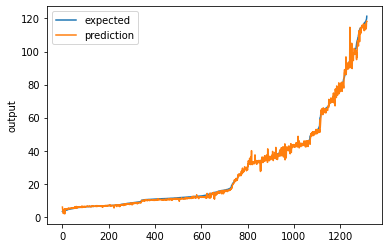

In [ ]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

print(parameters)
gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - Single layer",parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### *CASE 2: Multiple LSTM layer (2 layers)*

In [ ]:
layers={'lstm': [32 ,64] ,'Dense': 64}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'lstm': [32, 64], 'Dense': 64}, 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_layers_hp2.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
for i in range(5):
  model = Sequential()
  model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1,  activation='relu', input_shape=ip_size, return_sequences=True))
  model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1,  activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=100)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00014: early stopping
Epoch 00008: early stopping
Epoch 00013: early stopping
Epoch 00015: early stopping
Epoch 00011: early stopping
Elapsed time: 111.78141593933105


###### CASE 2: Model Performance Evaluation

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 7, 32)             4864      
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                24832     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 33,921
Trainable params: 33,921
Non-trainable params: 0
_________________________________________________________________

-------- Performance Evalutation for  RNN-LSTM - Multiple layers (2 layers)  --------
-------- Parameters:  {'layers': {'lstm': [32, 64], 'Dense': 64}, 'activation': ['ReLu'], 'optimizer': ['adam']}  --------

RMSE         : 1.7018794
MSE         

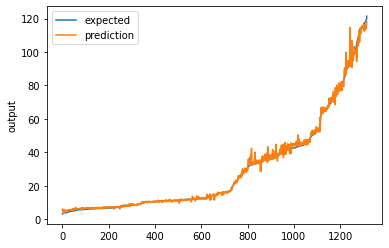

In [ ]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - Multiple layers (2 layers)", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### CASE 3: Multiple LSTM layers (3 layers)

In [ ]:
layers={'lstm': [32 ,64 , 128] ,'Dense': 64}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'lstm': [32, 64, 128], 'Dense': 64}, 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_layers_hp3.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
for i in range(5):
  model = Sequential()
  model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1,  activation='relu', input_shape=ip_size, return_sequences=True))
  model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1,  activation='relu', return_sequences=True))
  model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1,  activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=100)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00008: early stopping
Epoch 00007: early stopping
Epoch 00007: early stopping
Epoch 00006: early stopping
Epoch 00009: early stopping
Elapsed time: 153.98809051513672


###### CASE 3: Model Performance Evaluation

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 7, 32)             4864      
_________________________________________________________________
lstm_28 (LSTM)               (None, 7, 64)             24832     
_________________________________________________________________
lstm_29 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 136,833
Trainable params: 136,833
Non-trainable params: 0
_________________________________________________________________

-------- Performance Evalutation for  RNN-LSTM - Multiple layer (3 layers)  --------
-------- Parameters:  {'lay

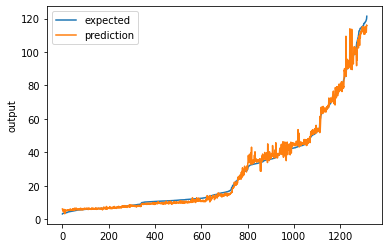

In [ ]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - Multiple layer (3 layers)",parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### CASE 4: Neuron Count -64

In [ ]:
neuron_count = 64
layers=['Lstm', 'Dense']
activation=["ReLu"]
optimizer=["adam"]
parameters={'neuron count': neuron_count, 'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'neuron count': 64, 'layers': ['Lstm', 'Dense'], 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_neuron_hp4.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
for i in range(5):
  model = Sequential()
  model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1,  activation='relu', input_shape=ip_size))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=100)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00012: early stopping
Epoch 00013: early stopping
Epoch 00008: early stopping
Epoch 00014: early stopping
Epoch 00015: early stopping
Elapsed time: 66.73624849319458


###### CASE 2: Model Performance Evaluation

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_30 (LSTM)               (None, 64)                17920     
_________________________________________________________________
dense_34 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_35 (Dense)             (None, 1)                 65        
Total params: 22,145
Trainable params: 22,145
Non-trainable params: 0
_________________________________________________________________

-------- Performance Evalutation for  RNN-LSTM - Neuron Count-64  --------
-------- Parameters:  {'neuron count': 64, 'layers': ['Lstm', 'Dense'], 'activation': ['ReLu'], 'optimizer': ['adam']}  --------

RMSE         : 1.6508224
MSE          : 2.7252147
R2 score     : 0.9966816185388686

-------- Regression Chart --------


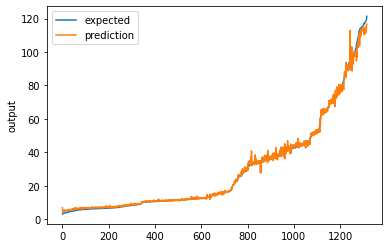

In [ ]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - Neuron Count-64", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### CASE 5: Neuron Count -128

In [ ]:
neuron_count = 128
layers=['Lstm', 'Dense']
activation=["ReLu"]
optimizer=["adam"]
parameters={'neuron count': neuron_count, 'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'neuron count': 128, 'layers': ['Lstm', 'Dense'], 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_neuron_hp5.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
for i in range(5):
  model = Sequential()
  model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1,  activation='relu', input_shape=ip_size))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=100)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00010: early stopping
Epoch 00013: early stopping
Epoch 00009: early stopping
Epoch 00009: early stopping
Epoch 00014: early stopping
Elapsed time: 96.94907808303833


###### CASE 2: Model Performance Evaluation

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 128)               68608     
_________________________________________________________________
dense_38 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 65        
Total params: 76,929
Trainable params: 76,929
Non-trainable params: 0
_________________________________________________________________

-------- Performance Evalutation for  RNN-LSTM - Neuron Count-128  --------
-------- Parameters:  {'neuron count': 128, 'layers': ['Lstm', 'Dense'], 'activation': ['ReLu'], 'optimizer': ['adam']}  --------

RMSE         : 1.6641436
MSE          : 2.7693737
R2 score     : 0.9966278477798206

-------- Regression Chart --------


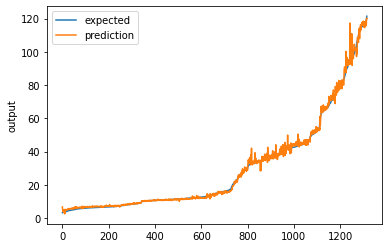

In [ ]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - Neuron Count-128", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### CASE 6: Neuron Count - 256

In [ ]:
neuron_count = 256
layers=['Lstm', 'Dense']
activation=["ReLu"]
optimizer=["adam"]
parameters={'neuron count': neuron_count, 'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'neuron count': 256, 'layers': ['Lstm', 'Dense'], 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_neuron_hp6.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
for i in range(5):
  model = Sequential()
  model.add(LSTM(256, dropout=0.1, recurrent_dropout=0.1,  activation='relu', input_shape=ip_size))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=100)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00015: early stopping
Epoch 00010: early stopping
Epoch 00008: early stopping
Epoch 00014: early stopping
Epoch 00024: early stopping
Elapsed time: 323.44065260887146


###### CASE 5: Model Performance Evaluation

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_39 (LSTM)               (None, 256)               268288    
_________________________________________________________________
dense_48 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 65        
Total params: 284,801
Trainable params: 284,801
Non-trainable params: 0
_________________________________________________________________

-------- Performance Evalutation for  RNN-LSTM - Neuron Count-256  --------
-------- Parameters:  {'neuron count': 256, 'layers': ['Lstm', 'Dense'], 'activation': ['ReLu'], 'optimizer': ['adam']}  --------

RMSE         : 1.435091
MSE          : 2.0594862
R2 score     : 0.9974922487809714

-------- Regression Chart --------


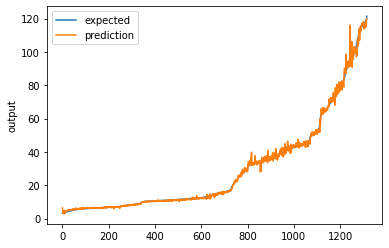

In [ ]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - Neuron Count-256", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### CASE 7: Neuron Count - 512

In [ ]:
neuron_count = 512
layers=['Lstm', 'Dense']
activation=["ReLu"]
optimizer=["adam"]
parameters={'neuron count': neuron_count, 'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'neuron count': 512, 'layers': ['Lstm', 'Dense'], 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_neuron_hp7.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
for i in range(5):
  model = Sequential()
  model.add(LSTM(512, dropout=0.1, recurrent_dropout=0.1,  activation='relu', input_shape=ip_size))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.10))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.10))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=100)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00009: early stopping
Epoch 00006: early stopping
Epoch 00005: early stopping
Epoch 00005: early stopping
Epoch 00006: early stopping
Elapsed time: 546.3698079586029


###### CASE 7: Model Performance Evaluation

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_43 (LSTM)               (None, 512)               1060864   
_________________________________________________________________
dense_66 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_67 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 65        
Total params: 1,134,849
Trainable params: 1,134,849
Non-trainable params: 0
___________________________________________

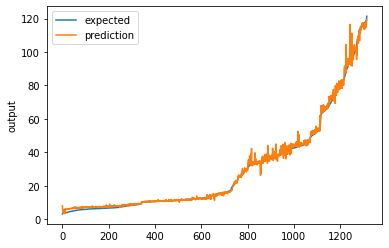

In [ ]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - Neuron Count -512", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### CASE 8: Neuron Count: 64, 128, 512

In [10]:
layers={'lstm': [64, 128, 512] ,'Dense': 64}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'lstm': [64, 128, 512], 'Dense': 64}, 'activation': ['ReLu'], 'optimizer': ['adam']}


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_layers_hp8.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
for i in range(5):
  model = Sequential()
  model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1,  activation='relu', input_shape=ip_size, return_sequences=True))
  model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1,  activation='relu', return_sequences=True))
  model.add(LSTM(512, dropout=0.1, recurrent_dropout=0.1,  activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=100)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00006: early stopping
Epoch 00011: early stopping
Epoch 00006: early stopping
Epoch 00007: early stopping
Epoch 00010: early stopping
Elapsed time: 912.4840664863586


###### CASE 8: Model Performance Evaluation

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 7, 64)             17920     
_________________________________________________________________
lstm_13 (LSTM)               (None, 7, 128)            98816     
_________________________________________________________________
lstm_14 (LSTM)               (None, 512)               1312768   
_________________________________________________________________
dense_8 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 1,462,401
Trainable params: 1,462,401
Non-trainable params: 0
_________________________________________________________________

-------- Performance Evalutation for  RNN-LSTM - Neuron Count: 64, 128, 512  --------
-------- Parameters:  {

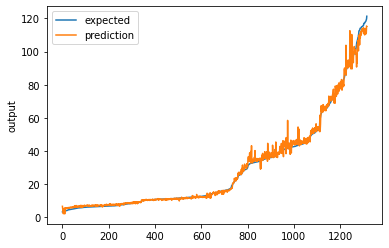

In [12]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - Neuron Count: 64, 128, 512",parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### CASE 9: Neuron Count: 512, 128, 64

In [13]:
layers={'lstm': [512, 128, 64] ,'Dense': 64}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'lstm': [512, 128, 64], 'Dense': 64}, 'activation': ['ReLu'], 'optimizer': ['adam']}


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_layers_hp9.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
for i in range(5):
  model = Sequential()
  model.add(LSTM(512, dropout=0.1, recurrent_dropout=0.1,  activation='relu', input_shape=ip_size, return_sequences=True))
  model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1,  activation='relu', return_sequences=True))
  model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1,  activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=100)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00008: early stopping
Epoch 00008: early stopping
Epoch 00005: early stopping
Epoch 00005: early stopping
Epoch 00006: early stopping
Elapsed time: 731.3139019012451


###### CASE 9: Model Performance Evaluation

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 7, 512)            1060864   
_________________________________________________________________
lstm_28 (LSTM)               (None, 7, 128)            328192    
_________________________________________________________________
lstm_29 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 1,442,689
Trainable params: 1,442,689
Non-trainable params: 0
_________________________________________________________________

-------- Performance Evalutation for  RNN-LSTM - Neuron Count: 512, 128, 64  --------
-------- Parameters:  {

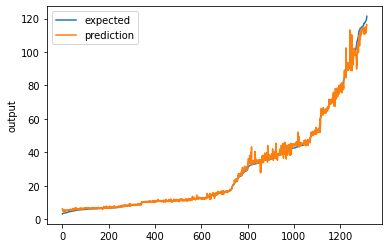

In [15]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - Neuron Count: 512, 128, 64",parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### CASE 10: Neuron Count: 32, 64, 128

In [16]:
layers={'lstm': [ 32, 64, 128] ,'Dense': 64}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'lstm': [32, 64, 128], 'Dense': 64}, 'activation': ['ReLu'], 'optimizer': ['adam']}


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_layers_hp10.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
for i in range(5):
  model = Sequential()
  model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1,  activation='relu', input_shape=ip_size, return_sequences=True))
  model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1,  activation='relu', return_sequences=True))
  model.add(LSTM(128, dropout=0.1, recurrent_dropout=0.1,  activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=100)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00007: early stopping
Epoch 00006: early stopping
Epoch 00014: early stopping
Epoch 00011: early stopping
Epoch 00010: early stopping
Elapsed time: 185.95619559288025


###### CASE 10: Model Performance Evaluation

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 7, 32)             4864      
_________________________________________________________________
lstm_43 (LSTM)               (None, 7, 64)             24832     
_________________________________________________________________
lstm_44 (LSTM)               (None, 128)               98816     
_________________________________________________________________
dense_28 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 136,833
Trainable params: 136,833
Non-trainable params: 0
_________________________________________________________________

-------- Performance Evalutation for  RNN-LSTM - Neuron Count:  32, 64, 128  --------
-------- Parameters:  {'la

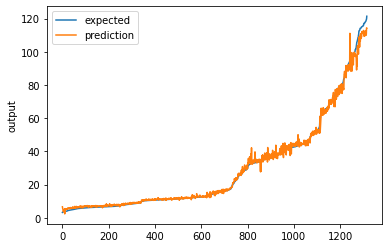

In [18]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - Neuron Count:  32, 64, 128",parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### CASE 11: Neuron Count: 100, 50, 80

In [19]:
layers={'lstm': [100, 50, 80] ,'Dense': 64}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'lstm': [100, 50, 80], 'Dense': 64}, 'activation': ['ReLu'], 'optimizer': ['adam']}


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_layers_hp11.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
for i in range(5):
  model = Sequential()
  model.add(LSTM(100, dropout=0.1, recurrent_dropout=0.1,  activation='relu', input_shape=ip_size, return_sequences=True))
  model.add(LSTM(50, dropout=0.1, recurrent_dropout=0.1,  activation='relu', return_sequences=True))
  model.add(LSTM(80, dropout=0.1, recurrent_dropout=0.1,  activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=100)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00009: early stopping
Epoch 00007: early stopping
Epoch 00009: early stopping
Epoch 00007: early stopping
Epoch 00006: early stopping
Elapsed time: 159.4035301208496


###### CASE 11: Model Performance Evaluation

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_57 (LSTM)               (None, 7, 100)            42400     
_________________________________________________________________
lstm_58 (LSTM)               (None, 7, 50)             30200     
_________________________________________________________________
lstm_59 (LSTM)               (None, 80)                41920     
_________________________________________________________________
dense_38 (Dense)             (None, 64)                5184      
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 65        
Total params: 119,769
Trainable params: 119,769
Non-trainable params: 0
_________________________________________________________________

-------- Performance Evalutation for  RNN-LSTM - Neuron Count:  100, 50, 80  --------
-------- Parameters:  {'la

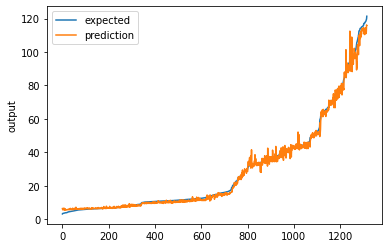

In [21]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - Neuron Count:  100, 50, 80",parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### CASE 12: Neuron Count: 60, 30, 20

In [22]:
layers={'lstm': [60, 30, 20] ,'Dense': 64}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'lstm': [60, 30, 20], 'Dense': 64}, 'activation': ['ReLu'], 'optimizer': ['adam']}


In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_layers_hp12.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
for i in range(5):
  model = Sequential()
  model.add(LSTM(60, dropout=0.1, recurrent_dropout=0.1,  activation='relu', input_shape=ip_size, return_sequences=True))
  model.add(LSTM(30, dropout=0.1, recurrent_dropout=0.1,  activation='relu', return_sequences=True))
  model.add(LSTM(20, dropout=0.1, recurrent_dropout=0.1,  activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=100)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00006: early stopping
Epoch 00008: early stopping
Epoch 00010: early stopping
Epoch 00006: early stopping
Epoch 00014: early stopping
Elapsed time: 124.10226702690125


###### CASE 12: Model Performance Evaluation

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_72 (LSTM)               (None, 7, 60)             15840     
_________________________________________________________________
lstm_73 (LSTM)               (None, 7, 30)             10920     
_________________________________________________________________
lstm_74 (LSTM)               (None, 20)                4080      
_________________________________________________________________
dense_48 (Dense)             (None, 64)                1344      
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 65        
Total params: 32,249
Trainable params: 32,249
Non-trainable params: 0
_________________________________________________________________

-------- Performance Evalutation for  RNN-LSTM - Neuron Count:  60, 30, 20  --------
-------- Parameters:  {'layer

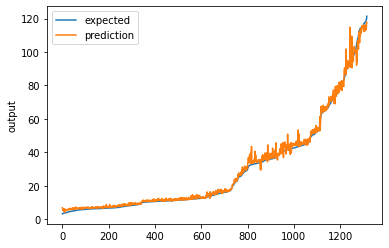

In [24]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - Neuron Count:  60, 30, 20",parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

#### ***Dropout tuning***

##### CASE 1: Without Regular and Recurrent dropout

In [ ]:
layers={'lstm': [128 ,64] ,'Dense': 64}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'lstm': [128, 64], 'Dense': 64}, 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_dropout_hp1.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
for i in range(5):
  model = Sequential()
  model.add(LSTM(128, activation='relu', input_shape=ip_size, return_sequences=True))
  model.add(LSTM(64, activation='relu'))
  model.add(Dense(32,activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=100)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00007: early stopping
Epoch 00011: early stopping
Epoch 00017: early stopping
Epoch 00012: early stopping
Epoch 00008: early stopping
Elapsed time: 83.93731212615967


###### CASE 1: Model Performance Evaluation

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_48 (LSTM)               (None, 7, 128)            68608     
_________________________________________________________________
lstm_49 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_58 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 33        
Total params: 120,129
Trainable params: 120,129
Non-trainable params: 0
_________________________________________________________________

-------- Performance Evalutation for  RNN-LSTM - Without Dropout  --------
-------- Parameters:  {'layers': {'lstm': [128, 64], 'Dense': 64}, 'activation': ['ReLu'], 'optimizer': ['adam']}  --------

RMSE         : 1.66804
MSE          : 2.7823

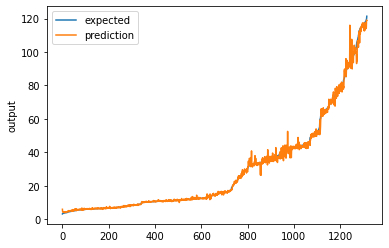

In [ ]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - Without Dropout",parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### CASE 2: With Regular Dropout

In [ ]:
layers={'lstm': [128 ,64] ,'Dense': 32}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'lstm': [128, 64], 'Dense': 32}, 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_dropout_hp2.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
for i in range(5):
  model = Sequential()
  model.add(LSTM(128, dropout=0.2, activation='relu', input_shape=ip_size, return_sequences=True))
  model.add(LSTM(64, dropout=0.2, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=100)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00007: early stopping
Epoch 00011: early stopping
Epoch 00008: early stopping
Epoch 00007: early stopping
Epoch 00005: early stopping
Elapsed time: 63.20035743713379


###### CASE 2: Model Performance Evaluation

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, 7, 128)            68608     
_________________________________________________________________
lstm_59 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_68 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_69 (Dense)             (None, 1)                 33        
Total params: 120,129
Trainable params: 120,129
Non-trainable params: 0
_________________________________________________________________

-------- Performance Evalutation for  RNN-LSTM - Regular Dropout  --------
-------- Parameters:  {'layers': {'lstm': [128, 64], 'Dense': 32}, 'activation': ['ReLu'], 'optimizer': ['adam']}  --------

RMSE         : 2.65268
MSE          : 7.0367

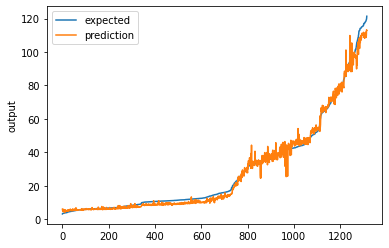

In [ ]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - Regular Dropout", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### CASE 3: With Recurrent Dropout

In [ ]:
layers={'lstm': [128 ,64] ,'Dense': 32}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'lstm': [128, 64], 'Dense': 32}, 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_dropout_hp3.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
for i in range(5):
  model = Sequential()
  model.add(LSTM(128, recurrent_dropout=0.2, activation='relu', input_shape=ip_size, return_sequences=True))
  model.add(LSTM(64, recurrent_dropout=0.2, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=100)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00010: early stopping
Epoch 00008: early stopping
Epoch 00018: early stopping
Epoch 00010: early stopping
Epoch 00008: early stopping
Elapsed time: 149.23184394836426


###### CASE 3: Model Performance Evaluation

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_68 (LSTM)               (None, 7, 128)            68608     
_________________________________________________________________
lstm_69 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_78 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 33        
Total params: 120,129
Trainable params: 120,129
Non-trainable params: 0
_________________________________________________________________

-------- Performance Evalutation for  RNN-LSTM - Recurrent Dropout  --------
-------- Parameters:  {'layers': {'lstm': [128, 64], 'Dense': 32}, 'activation': ['ReLu'], 'optimizer': ['adam']}  --------

RMSE         : 1.5237576
MSE          : 2.

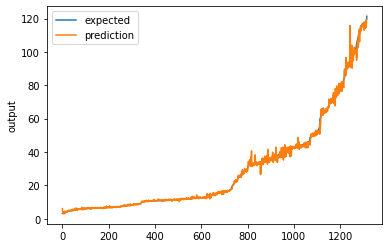

In [ ]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - Recurrent Dropout", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### CASE 4: With Regular + Recurrent dropout - 20%

In [ ]:
layers={'lstm': [128 ,64] ,'Dense': 64}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'lstm': [128, 64], 'Dense': 64}, 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_dropout_hp4.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
for i in range(5):
  model = Sequential()
  model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2,  activation='relu', input_shape=ip_size, return_sequences=True))
  model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2,  activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=100)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00008: early stopping
Epoch 00005: early stopping
Epoch 00009: early stopping
Epoch 00011: early stopping
Epoch 00008: early stopping
Elapsed time: 131.71363878250122


###### CASE 4: Model Performance Evaluation

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_88 (LSTM)               (None, 7, 128)            68608     
_________________________________________________________________
lstm_89 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_98 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_99 (Dense)             (None, 1)                 65        
Total params: 122,241
Trainable params: 122,241
Non-trainable params: 0
_________________________________________________________________

-------- Performance Evalutation for  RNN-LSTM - Recurrent + Dropout - 20%  --------
-------- Parameters:  {'layers': {'lstm': [128, 64], 'Dense': 64}, 'activation': ['ReLu'], 'optimizer': ['adam']}  --------

RMSE         : 2.908155
MSE       

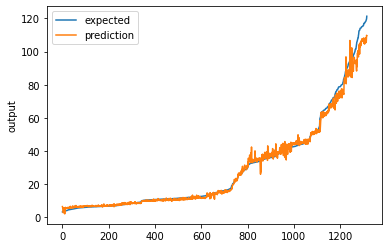

In [ ]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - Recurrent + Dropout - 20%", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### CASE 5: With Regular + Recurrent dropout - 50%

In [ ]:
layers={'lstm': [128 ,64] ,'Dense': 64}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'lstm': [128, 64], 'Dense': 64}, 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_dropout_hp5.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
for i in range(5):
  model = Sequential()
  model.add(LSTM(128, dropout=0.50, recurrent_dropout=0.50,  activation='relu', input_shape=ip_size, return_sequences=True))
  model.add(LSTM(64, dropout=0.50, recurrent_dropout=0.50,  activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=100)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00004: early stopping
Epoch 00005: early stopping
Epoch 00005: early stopping
Epoch 00005: early stopping
Epoch 00006: early stopping
Elapsed time: 89.32769823074341


###### CASE 5: Model Performance Evaluation

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_98 (LSTM)               (None, 7, 128)            68608     
_________________________________________________________________
lstm_99 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_108 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_109 (Dense)            (None, 1)                 65        
Total params: 122,241
Trainable params: 122,241
Non-trainable params: 0
_________________________________________________________________

-------- Performance Evalutation for  RNN-LSTM - Recurrent + Dropout - 50%  --------
-------- Parameters:  {'layers': {'lstm': [128, 64], 'Dense': 64}, 'activation': ['ReLu'], 'optimizer': ['adam']}  --------

RMSE         : 6.546654
MSE       

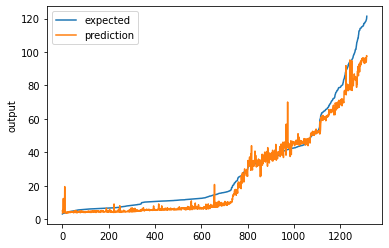

In [ ]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - Recurrent + Dropout - 50%", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

#### ***Optimizer- Activation function tuning***

##### CASE 1: Adam-ReLU

In [ ]:
layers={'lstm': [64 ,32] ,'Dense': 32}
activation=["ReLu"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'lstm': [64, 32], 'Dense': 32}, 'activation': ['ReLu'], 'optimizer': ['adam']}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_optAct_hp1.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
for i in range(5):
  model = Sequential()
  model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1,  activation='relu', input_shape=ip_size, return_sequences=True))
  model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1,  activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=100)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00007: early stopping
Epoch 00013: early stopping
Epoch 00012: early stopping
Epoch 00010: early stopping
Epoch 00008: early stopping
Elapsed time: 99.71998000144958


###### CASE 2: Model Performance Evaluation

Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_108 (LSTM)              (None, 7, 64)             17920     
_________________________________________________________________
lstm_109 (LSTM)              (None, 32)                12416     
_________________________________________________________________
dense_118 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_119 (Dense)            (None, 1)                 33        
Total params: 31,425
Trainable params: 31,425
Non-trainable params: 0
_________________________________________________________________

-------- Performance Evalutation for  RNN-LSTM - ADAM-ReLU  --------
-------- Parameters:  {'layers': {'lstm': [64, 32], 'Dense': 32}, 'activation': ['ReLu'], 'optimizer': ['adam']}  --------

RMSE         : 1.7163142
MSE          : 2.9457343
R2 

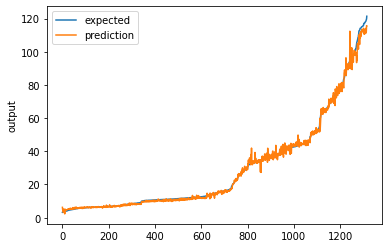

In [ ]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - ADAM-ReLU", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### CASE 2: Adam-Sigmoid

In [ ]:
layers={'lstm': [512 ,128] ,'Dense': 64}
activation=["sigmoid"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'lstm': [512, 128], 'Dense': 64}, 'activation': ['sigmoid'], 'optimizer': ['adam']}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_optAct_hp2.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
custom_adam= optimizers.Adam(beta_1=0.8, beta_2=0.7)
for i in range(5):
  model = Sequential()
  model.add(LSTM(64, activation='sigmoid', input_shape=ip_size, return_sequences=True))
  model.add(LSTM(32, activation='sigmoid'))
  model.add(Dense(128, activation='sigmoid'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer=custom_adam)
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=100)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00021: early stopping
Epoch 00024: early stopping
Epoch 00021: early stopping
Epoch 00019: early stopping
Epoch 00017: early stopping
Elapsed time: 92.78431177139282


###### CASE 2: Model Performance Evaluation

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_24 (LSTM)               (None, 7, 64)             17920     
_________________________________________________________________
lstm_25 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_24 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 129       
Total params: 34,689
Trainable params: 34,689
Non-trainable params: 0
_________________________________________________________________

-------- Performance Evalutation for  RNN-LSTM - Adam-Sigmoid  --------
-------- Parameters:  {'layers': {'lstm': [64, 32], 'Dense': 32}, 'activation': ['ReLu'], 'optimizer': ['sgd']}  --------

RMSE         : 0.95701057
MSE          : 0.91586924

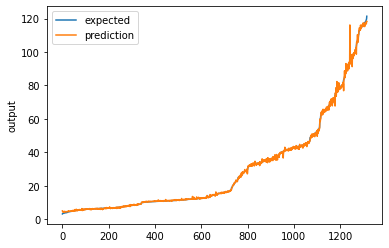

In [ ]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - Adam-Sigmoid", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### CASE 3: Adam-Tanh

In [ ]:
layers={'lstm': [64 ,32] ,'Dense': 32}
activation=["tanh"]
optimizer=["adam"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'lstm': [64, 32], 'Dense': 32}, 'activation': ['tanh'], 'optimizer': ['adam']}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_optAct_hp3.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
for i in range(5):
  model = Sequential()
  model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1,  activation='tanh', input_shape=ip_size, return_sequences=True))
  model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1,  activation='tanh'))
  model.add(Dense(32, activation='tanh'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='adam')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=500)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00088: early stopping
Epoch 00074: early stopping
Epoch 00083: early stopping
Epoch 00076: early stopping
Epoch 00078: early stopping
Elapsed time: 613.8063967227936


###### CASE 3: Model Performance Evaluation

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_128 (LSTM)              (None, 7, 64)             17920     
_________________________________________________________________
lstm_129 (LSTM)              (None, 32)                12416     
_________________________________________________________________
dense_138 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_139 (Dense)            (None, 1)                 33        
Total params: 31,425
Trainable params: 31,425
Non-trainable params: 0
_________________________________________________________________

-------- Performance Evalutation for  RNN-LSTM - Adam-Tanh  --------
-------- Parameters:  {'layers': {'lstm': [64, 32], 'Dense': 32}, 'activation': ['tanh'], 'optimizer': ['adam']}  --------

RMSE         : 1.1522442
MSE          : 1.3276668
R2 

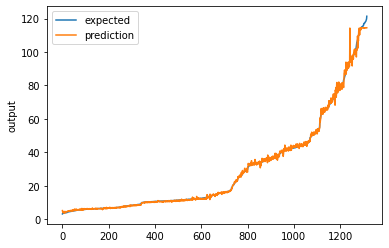

In [ ]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - Adam-Tanh", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### CASE 4: SGD-ReLU

In [ ]:
layers={'lstm': [64 ,32] ,'Dense': 32}
activation=["ReLu"]
optimizer=["sgd"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'lstm': [64, 32], 'Dense': 32}, 'activation': ['ReLu'], 'optimizer': ['sgd']}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_optAct_hp4.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)

custom_sgd = optimizers.SGD(lr=0.01 , clipvalue=0.5)

startTime = time.time()
for i in range(3):
  model = Sequential()
  model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1,  activation='relu', input_shape=ip_size, return_sequences=True))
  model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1,  activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer=custom_sgd)
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=500)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00017: early stopping
Epoch 00004: early stopping
Epoch 00017: early stopping
Elapsed time: 69.75421977043152


###### CASE 4: Model Performance Evaluation

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 7, 64)             17920     
_________________________________________________________________
lstm_15 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 31,425
Trainable params: 31,425
Non-trainable params: 0
_________________________________________________________________

-------- Performance Evalutation for  RNN-LSTM - SGD-ReLU  --------
-------- Parameters:  {'layers': {'lstm': [64, 32], 'Dense': 32}, 'activation': ['ReLu'], 'optimizer': ['sgd']}  --------

RMSE         : 5.6156015
MSE          : 31.53498
R2 scor

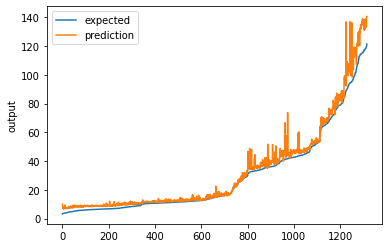

In [ ]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - SGD-ReLU", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### CASE 5: SGD-Sigmoid

In [ ]:
layers={'lstm': [64 ,32] ,'Dense': 32}
activation=["sigmoid"]
optimizer=["sgd"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'lstm': [64, 32], 'Dense': 32}, 'activation': ['sigmoid'], 'optimizer': ['sgd']}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_optAct_hp5.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
for i in range(3):
  model = Sequential()
  model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1,  activation='sigmoid', input_shape=ip_size, return_sequences=True))
  model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1,  activation='sigmoid'))
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='sgd')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=100)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00009: early stopping
Epoch 00008: early stopping
Epoch 00007: early stopping
Elapsed time: 49.05572438240051


###### CASE 5: Model Performance Evaluation

Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_142 (LSTM)              (None, 7, 64)             17920     
_________________________________________________________________
lstm_143 (LSTM)              (None, 32)                12416     
_________________________________________________________________
dense_152 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_153 (Dense)            (None, 1)                 33        
Total params: 31,425
Trainable params: 31,425
Non-trainable params: 0
_________________________________________________________________

-------- Performance Evalutation for  RNN-LSTM - SGD-Sigmoid  --------
-------- Parameters:  {'layers': {'lstm': [64, 32], 'Dense': 32}, 'activation': ['sigmoid'], 'optimizer': ['sgd']}  --------

RMSE         : 1.9055558
MSE          : 3.6311429

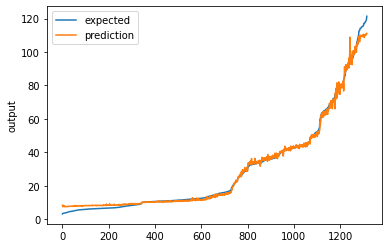

In [ ]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - SGD-Sigmoid", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)

##### CASE 6: SGD-Tanh

In [ ]:
layers={'lstm': [64 ,32] ,'Dense': 32}
activation=["tanh"]
optimizer=["sgd"]
parameters={'layers':layers, 'activation': activation, 'optimizer': optimizer}

print(parameters)

{'layers': {'lstm': [64, 32], 'Dense': 32}, 'activation': ['tanh'], 'optimizer': ['sgd']}


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import time


ip_size = (x_train.shape[1] , x_train.shape[2]) #input size of each record 7X5

# checkpoint to save the best weights 
filepath_savemodel = os.path.join(dnn_path,"p2_LSTM_optAct_hp6.hdf5")
checkpoint = ModelCheckpoint(filepath= filepath_savemodel, verbose=0, save_best_only=True)
startTime = time.time()
for i in range(3):
  model = Sequential()
  model.add(LSTM(64, dropout=0.1, recurrent_dropout=0.1,  activation='tanh', input_shape=ip_size, return_sequences=True))
  model.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1,  activation='tanh'))
  model.add(Dense(32, activation='tanh'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer='sgd')
  monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=3, verbose=1, mode='auto')
  model.fit(x_train,y_train,validation_data=(x_test,y_test), callbacks=[monitor, checkpoint],verbose=0, epochs=100)  

elapsedTime = time.time() - startTime
print(f"Elapsed time: {elapsedTime}")

model.load_weights(filepath_savemodel)

Epoch 00010: early stopping
Epoch 00010: early stopping
Epoch 00013: early stopping
Elapsed time: 63.45644426345825


###### CASE 6: Model Performance Evaluation

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_148 (LSTM)              (None, 7, 64)             17920     
_________________________________________________________________
lstm_149 (LSTM)              (None, 32)                12416     
_________________________________________________________________
dense_158 (Dense)            (None, 32)                1056      
_________________________________________________________________
dense_159 (Dense)            (None, 1)                 33        
Total params: 31,425
Trainable params: 31,425
Non-trainable params: 0
_________________________________________________________________

-------- Performance Evalutation for  RNN-LSTM - SGD-Tanh  --------
-------- Parameters:  {'layers': {'lstm': [64, 32], 'Dense': 32}, 'activation': ['tanh'], 'optimizer': ['sgd']}  --------

RMSE         : 1.3641465
MSE          : 1.8608955
R2 sc

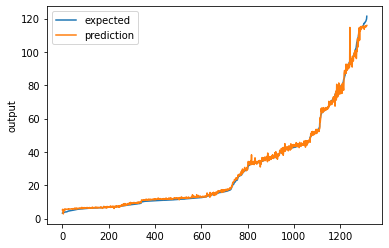

In [ ]:
# Model layer Summary
model.summary()

print()

# Predict
pred = model.predict(x_test)

gplot.regression_performance_metrics(y_test,pred,"RNN-LSTM - SGD-Tanh", parameters)
print()
gplot.chart_regression(pred.flatten(),y_test)